In [1]:
from langchain_core.tools import tool
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Optional
import os
import argparse
from pymongo import MongoClient
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from typing import List, Optional
from langchain_redis import RedisChatMessageHistory
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from dotenv import load_dotenv
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from typing import Dict, Any
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

load_dotenv()

class Message(BaseModel):
    role: str
    content: str

class ChatRequest(BaseModel):
    context: Optional[List[BaseMessage]] = Field(default_factory=list)
    text: str
    max_new_tokens: Optional[int] = 1024
    session_id: Optional[str] = None

/Users/tomasgutierrez/projects/flite/flite-ai/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
uri = os.getenv("MONGODB_URI")
mongo_client = MongoClient(uri, server_api=ServerApi("1"))

# Test the connection
try:
    mongo_client.admin.command('ping')
    print("Successfully connected to MongoDB!")
except Exception as e:
    print(f"Error connecting to MongoDB: {e}")
    exit(1)

db = mongo_client["RagAI"]
collection = db["embeddings"]
embedding_model = SentenceTransformer("BAAI/bge-m3", token=os.getenv('HUGGINGFACE_HUB_TOKEN'))

Error connecting to MongoDB: stagingdb-shard-00-00.qkslh.mongodb.net:27017: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1020) (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms),stagingdb-shard-00-01.qkslh.mongodb.net:27017: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1020) (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms),stagingdb-shard-00-02.qkslh.mongodb.net:27017: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1020) (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 686419719a49822ca6dfe6f6, topology_type: ReplicaSetNoPrimary, servers: [<ServerDescription ('stagingdb-shard-00-00.qkslh.mongodb.net', 27017) server_type: Unknown, rtt: None, error=AutoReconne

In [4]:
# Vector Search Function
def vector_search(user_query):
    # Get embedding for user query
    embedding = embedding_model.encode(user_query, normalize_embeddings=True)
    query_vector = embedding.tolist()

    # Build aggregation pipeline with $vectorSearch
    pipeline = [
        {
            "$vectorSearch": {
                "index": "test1",
                "path": "embedding",
                "queryVector": query_vector,
                "numCandidates": 100,
                "limit": 5,
                "similarity": "cosine"
            }
        },
        {
            "$project": {
                "_id": 0,
                "text": 1,
                "score": {"$meta": "vectorSearchScore"}
            }
        }
    ]

    results = list(collection.aggregate(pipeline))
    return results

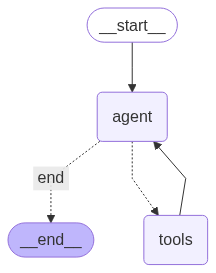

In [ ]:
# Create Promo Code Tool

@tool
def createPromoCode(event: str, name: str, type: str, value: float, limit: int) -> dict:
    """Creates a promo code for a Flite event."""
    return {
        "event": event,
        "name": name,
        "type": type,
        "value": value,
        "limit": limit
    }

# Send SMS Blast Tools

@tool
def sendEventMessage(event: str, message: str, insertFirstName: bool, audienceType: str, includeLink: bool, ticketType: str) -> dict:
    """
    Send a Flite SMS blast to attendees of a specific event.

    Only submit the tool call when all required and any desired optional fields are provided.

    - insertFirstName: 'yes' or 'no' — whether to personalize each message with the attendee's first name.
    - audienceType: One of 'Event Attendees', 'Abandoned Carts', or 'Update List'.
    - includeLink: 'yes' or 'no' — whether to include a link in the SMS.
    - ticketType: One of 'General Admission (GA)', 'Golden Pass', or 'Secret'.
    """
    return {
        "event": event,
        "message": message,
        "insertFirstName": insertFirstName,
        "audienceType": audienceType,
        "includeLink": includeLink,
        "ticketType": ticketType,
    }

@tool
def sendAudienceMessage(message: str, insertFirstName: bool, link: Optional[str] = None) -> dict:
    """Send a Flite SMS blast to a hosts entire fanbase/audience. Only submit the tool call when all required and user-desired optional fields are collected.
    
    - insertFirstName: 'yes' or 'no' — whether to personalize each message with the attendee's first name.
    - link: A link to include in the SMS."""
    return {
        "message": message,
        "insertFirstName": insertFirstName,
        "link": link,
    }

@tool
def sendCityMessage(city: str, message: str, insertFirstName: bool, link: Optional[str] = None) -> dict:
    """Send a Flite SMS blast to users that have attended any of the host's events in a specific city. Only submit the tool call when all required and user-desired optional fields are collected.
    
    - insertFirstName: 'yes' or 'no' — whether to personalize each message with the attendee's first name.
    - link: A link to include in the SMS."""
    return {
        "city": city,
        "message": message,
        "insertFirstName": insertFirstName,
        "link": link,
    }

# Send Email Blast Tools

@tool
def sendEventEmail(event: str, subject: str, email: str, audienceType: str, ticketType: str) -> dict:
    """
    Send a Flite Email blast to attendees of a specific event.

    Only submit the tool call when all required and any desired optional fields are provided.

    - subject: The subject of the email to send.
    - email: The content of the email to send.
    - audienceType: One of 'Event Attendees', 'Abandoned Carts', or 'Update List'.
    - ticketType: One of 'General Admission (GA)', 'Golden Pass', or 'Secret'.
    """
    return {
        "event": event,
        "subject": subject,
        "email": email,
        "audienceType": audienceType,
        "ticketType": ticketType,
    }

@tool
def sendAudienceEmail(subject: str, email: str, link: Optional[str] = None) -> dict:
    """Send a Flite Email blast to a hosts entire fanbase/audience. Only submit the tool call when all required and user-desired optional fields are collected.
    
    - subject: The subject of the email to send.
    - email: The content of the email to send.
    - link: A link to include in the email."""
    return {
        "subject": subject,
        "email": email,
        "link": link,
    }

@tool
def sendCityEmail(city: str, subject: str, email: str, link: Optional[str] = None) -> dict:
    """Send a Flite Email blast to users that have attended any of the host's events in a specific city. Only submit the tool call when all required and user-desired optional fields are collected.
    
    - city: The specified city.
    - subject: The subject of the email to send.
    - email: The content of the email to send.
    - link: A link to include in the email."""
    return {
        "city": city,
        "subject": subject,
        "email": email,
        "link": link,
    }

# Send Notification Blast Tools

@tool
def sendNotifications(title: str, message: str) -> dict:
    """
    Send a Flite Notification blast to all of a host's fans who have the mobile app.

    Only submit the tool call when all required and any desired optional fields are provided.

    - title: The title of the notification to send.
    - message: The content of the notification to send.
    """
    return {
        "title": title,
        "message": message,
    }

tools = [createPromoCode, sendEventMessage, sendAudienceMessage, sendCityMessage, sendEventEmail, sendAudienceEmail, sendCityEmail, sendNotifications]

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4.1-2025-04-14",
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: List[BaseMessage]

def agent_node(state: State) -> State:
    messages = state["messages"]
    query = messages[-1].content
    
    # Check if last message is a tool result
    if hasattr(messages[-1], 'type') and messages[-1].type == "tool":
        # Tool was just executed, provide final response
        tool_result = messages[-1]
        prompt = (
            f"A tool was just executed successfully. "
            f"Tool result: {tool_result.content}\n\n"
            f"Provide a brief confirmation to the user that the action was completed."
        )
    else:
        # Normal query processing
        search_results = vector_search(query)
        context_block = "\n".join(
            f"{'User' if msg.type == 'human' else 'Assistant'}: {msg.content}"
            for msg in messages
        )
        
        snippets = "\n\n".join(
            "- " + search_result["text"][:200].replace("\n", " ") for search_result in search_results
        )

        prompt = (
            f"You are a helpful assistant. Use the previous conversation and the retrieved document snippets to answer the query.\n\n"
            f"When the user needs to provide information for a tool call, "
            f"ask for the missing required and optional fields using the following strict format:\n\n"
            f"- [Short description or question about field]\n\n"
            f"Leave exactly one blank line between each bullet.\n\n"
            f"Example:\n"
            f"- What is the event?\n\n"
            f"- Would you like to include a link in your message?\n\n"
            f"- Who is the audience for this message?\n\n"
            f"- What ticket type are you interested in?\n\n"
            f"Do NOT mention tools, internal functions, or system information.\n\n"
            f"Previous Messages:\n{context_block}\n\n"
            f"Query: {query}\n\n"
            f"Snippets:\n{snippets}\n\n"
            "Answer:"
        )

    ai_msg = llm_with_tools.invoke(prompt)
    return {"messages": messages + [ai_msg]}

def my_tools_condition(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If last message is a tool result, go to agent to respond
    if hasattr(last_message, 'type') and last_message.type == "tool":
        return "agent"
    
    # If last message is AI and has tool calls, go to tools
    if last_message.type == "ai" and getattr(last_message, "tool_calls", None):
        return "tools"
    
    # Otherwise end
    return "end"

builder = StateGraph(State)
builder.add_node("agent", agent_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    my_tools_condition,
    {
        "tools": "tools",
        "end": END
    }
)

builder.add_edge("tools", "agent")
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [45]:
history = RedisChatMessageHistory(
    session_id="anonymous",
    redis_url=os.getenv("REDIS_URL"),
    ttl=3600
)

20:45:56 redisvl.index.index INFO   Index already exists, not overwriting.


In [44]:
history.clear()

In [52]:
user_msg = HumanMessage(content="""content is this
hi guys, 
                        
hope to see you all soon at the NYE party!!

best, Tomas

no link""")
history.add_message(user_msg)

state = {
    "messages": history.messages
}

result = graph.invoke(state)

final_ai = next(m for m in reversed(result["messages"]) if m.type == "ai")
tool_results = [m for m in reversed(result["messages"]) if m.type == "tool"]

history.add_message(final_ai)
print(final_ai.content)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


20:47:57 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
20:47:57 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Your email about the New Year's Eve Party has been sent successfully.


In [58]:
print(type(tool_results))

<class 'list'>


In [54]:
print(history.messages)

[HumanMessage(content='hi there!', additional_kwargs={}, response_metadata={}), AIMessage(content='Hey! 😎 I’m your Flite Assistant, ready to help you make your next event a smash hit! Need help with tickets, promoting, or hyping things up? Just let me know what you want to do!', additional_kwargs={'refusal': None}, response_metadata={}), HumanMessage(content='can you help me send an email blast?', additional_kwargs={}, response_metadata={}), AIMessage(content='- What is the subject of your email?\n\n- What is the content of your email?\n\n- Who is the audience for this email blast? (For example: your entire fanbase, event attendees, a test segment, or users in a specific city)\n\n- Would you like to include a link in your email? If yes, please provide the link.\n\n- If sending to event attendees, what ticket type should receive the email? (General Admission, Golden Pass, Secret)', additional_kwargs={'refusal': None}, response_metadata={}), HumanMessage(content='email blast is for my wh

In [42]:
i = len(result["messages"]) - 1
tool_msg = None
while i >= 0 and result["messages"][i].type != "human":
    if result["messages"][i].type == "tool":
        tool_msg = result["messages"][i]
        break
    i -= 1

print(tool_msg.content)

{"city": "NYC", "subject": "TESTING", "email": "hi there,\n\nhope to see you soon at NYE party!!\n\nfrom, tomas", "link": null}
